# Estratégias de Sampling para Modelos de Classificação Imbalanceados

Este notebook demonstra o uso de diferentes estratégias de sampling (Undersampling, Oversampling e Cost-Sensitive Learning) para lidar com datasets desbalanceados em problemas de classificação.

**Modelo Inicial:** LSTM

**Métricas de Avaliação:** F1-score, Precisão Média (Average Precision) e Curva Precision-Recall.

In [40]:
!pip install skorch

# 1. Importar Bibliotecas Necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, average_precision_score, precision_recall_curve, PrecisionRecallDisplay

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# Baixar funções compartilhadas, se necessário
if not os.path.exists('shared_functions.py'):
    import urllib.request
    urllib.request.urlretrieve(
        'https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py',
        'shared_functions.py'
    )

from shared_functions import *

%pip install graphviz

# Carregar funções compartilhadas e dados reais, conforme Anomaly.ipynb
import os
import datetime

import warnings
warnings.filterwarnings('ignore')

## 2. Importação de Dados Sintéticos (Exemplo)

Para fins de demonstração, vamos utilizar um dataset gerado por simulação desbalanceado. Em um cenário real, você carregaria seu próprio dataset.

In [3]:
# Baixar dados simulados, se necessário
if not os.path.exists('simulated-data-transformed'):
    os.system('git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed')

DIR_INPUT = 'simulated-data-transformed/data/'
BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load files")
transactions_df = read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print(f"{len(transactions_df)} transactions loaded, containing {transactions_df.TX_FRAUD.sum()} fraudulent transactions")

output_feature = "TX_FRAUD"
input_features = [
    'TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
    'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
    'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
    'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
    'TERMINAL_ID_RISK_30DAY_WINDOW'
]

categorical_features = ['TX_DURING_WEEKEND', 'TX_DURING_NIGHT']
continuous_features = list(set(input_features) - set(categorical_features))

# Separar treino e teste conforme o handbook
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train = 7
delta_delay = 7
delta_test = 7
delta_valid = delta_test
start_date_training_with_valid = start_date_training + datetime.timedelta(days=-(delta_delay+delta_valid))
train_df, test_df = get_train_test_set(transactions_df, start_date_training_with_valid, delta_train=delta_train, delta_delay=delta_delay, delta_test=delta_test)

# Escalar os dados

# standard scaler para features contínuas é adequado
std_scaler = StandardScaler()
std_scaler.fit(train_df[continuous_features])
train_df[continuous_features] = std_scaler.transform(train_df[continuous_features])
test_df[continuous_features] = std_scaler.transform(test_df[continuous_features])

# label encoder para features categóricas é mais apropriado
for col in categorical_features:
    le = LabelEncoder()
    # assume que o treinamento possui exemplos com todos valores:
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

X_train = train_df[input_features].values
X_test = test_df[input_features].values
y_train = train_df[output_feature].values
y_test = test_df[output_feature].values

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Distribuição das classes em y_train: {pd.Series(y_train).value_counts()}")

Load files
919767 transactions loaded, containing 8195 fraudulent transactions
Shape de X_train: (66928, 15)
Shape de y_train: (66928,)
Distribuição das classes em y_train: 0    66295
1      633
Name: count, dtype: int64


# Preparando o Dataset

Para modelos sequenciais, é necessário preparar o dataset para fornecer as sequências que o modelo espera

Esta primeira implementação é apenas para exemplificar o raciocínio de janela deslizante que se utiliza para a criação do dataset

In [4]:
# Ordenando cronologicamente
# mapeia os indíces ordenados com não ordenados
indices_sort = np.argsort(train_df['TX_DATETIME'].values)
# aplica ordenação
sorted_dates = train_df['TX_DATETIME'].values[indices_sort]
sorted_ids = train_df['CUSTOMER_ID'].values[indices_sort]

# Pegando os ids de clientes sem repetição
unique_customer_ids = np.unique(sorted_ids)

# Então, montando sequências para cada customer:
def sliding_window(customer_transactions, window):
    start_fill = np.zeros((window - 1)) - 1
    a = np.concatenate([start_fill, customer_transactions])
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides).astype(int)

# por exemplo as sequências para um customer qualquer pode ser pega assim:
# Escolhendo arbitrariamente o tamanho da sequência para o ds de treino
indice = 27
customer_id = unique_customer_ids[indice]
customer_transactions = indices_sort[np.where(sorted_ids == customer_id)[0]]

print(
    f"Por exemplo, as janelas deslizantes de transações do cliente {customer_id}:\n",
    sliding_window(
        customer_transactions,
        5
    )
)

Por exemplo, as janelas deslizantes de transações do cliente 29:
 [[   -1    -1    -1    -1  4493]
 [   -1    -1    -1  4493  6621]
 [   -1    -1  4493  6621  9015]
 [   -1  4493  6621  9015 12214]
 [ 4493  6621  9015 12214 16152]
 [ 6621  9015 12214 16152 24120]
 [ 9015 12214 16152 24120 28191]
 [12214 16152 24120 28191 29263]
 [16152 24120 28191 29263 33409]
 [24120 28191 29263 33409 33757]
 [28191 29263 33409 33757 40610]
 [29263 33409 33757 40610 44988]
 [33409 33757 40610 44988 50333]
 [33757 40610 44988 50333 61840]
 [40610 44988 50333 61840 65758]]


Pode então ser implementada uma versão mais performática utilizando pandas

In [27]:
class FraudSequenceDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        x,
        y,
        customer_ids,
        dates,
        seq_len,
        padding_mode = 'zeros',
        output=True
    ):
        if padding_mode == "mean":
            self.features = np.vstack([x, x.mean(axis=0)])
        elif padding_mode == "zeros":
            self.features = np.vstack([x, np.zeros(x[0,:].shape)])
        else:
            raise ValueError('padding_mode must be "mean" or "zeros"')

        self.y = y
        self.customer_ids = customer_ids
        self.dates = dates
        self.seq_len = seq_len
        self.output = output

        # computando as sequências
        df_ids_dates = pd.DataFrame({'CUSTOMER_ID':customer_ids,
        'TX_DATETIME':dates})

        df_ids_dates["tmp_index"]  = np.arange(len(df_ids_dates))
        df_groupby_customer_id = df_ids_dates.groupby("CUSTOMER_ID")
        sequence_indices = pd.DataFrame(
            {
                "tx_{}".format(n): df_groupby_customer_id["tmp_index"].shift(seq_len - n - 1)
                for n in range(seq_len)
            }
        )

        # Substitui -1 (padding) com o index da transação padding
        self.sequences_ids = sequence_indices.fillna(len(self.features) - 1).values.astype(int)

    def __len__(self):
        # Não é len(self.features) por causa da adição de transções "padding"
        return len(self.sequences_ids)

    def __getitem__(self, index):
        tx_ids = self.sequences_ids[index]

        if self.output:
            #transposing because the CNN considers the channel dimension before the sequence dimension
            return self.features[tx_ids,:].astype(np.float32), self.y[index].astype(np.float32)
        else:
            return self.features[tx_ids,:].astype(np.float32)

# tamanho da sequência (arbitrário, geralmente utilizado de 5 a 10)
SEQUENCE_LEN = 5

training_set = FraudSequenceDataset(
  X_train,
  y_train,
  train_df['CUSTOMER_ID'].values,
  train_df['TX_DATETIME'].values,
  SEQUENCE_LEN,
  padding_mode="zeros"
)

test_set = FraudSequenceDataset(
    X_test,
    y_test,
    test_df['CUSTOMER_ID'].values,
    test_df['TX_DATETIME'].values,
    SEQUENCE_LEN,
    padding_mode="zeros"
  )

## 3. Função de Avaliação do Modelo

Esta função encapsula o treinamento e a avaliação do modelo, facilitando a comparação entre as diferentes estratégias de sampling. Ela aceita um modelo e, opcionalmente, um pipeline de pré-processamento/sampling.

In [45]:
def train_model(model, train_ds):
    # Treinar o modelo
    model.fit(train_ds, y=train_ds.y)

def evaluate_model(model, test_ds, strategy_name="Baseline"):
    """
    Treina e avalia um modelo de classificação usando as métricas especificadas.
    """
    print(f"\n--- Avaliando: {strategy_name} ---")


    # Previsões
    y_pred = model.predict(test_ds)
    y_proba = model.predict_proba(test_ds)[:, 1]
    # print("len(y_pred)", len(y_pred))
    # print("np.sum(y_pred)", np.sum(y_pred))
    # print("np.sum(y_proba > 0.5)", np.sum(y_proba > 0.5))

    # Calcular métricas
    f1 = f1_score(test_ds.y, y_pred)
    avg_precision = average_precision_score(test_ds.y, y_proba)

    print(f"F1-score: {f1:.4f}")
    print(f"Precisão Média (Average Precision): {avg_precision:.4f}")

    # Plotar Curva Precision-Recall
    display = PrecisionRecallDisplay.from_predictions(
        test_ds.y, y_proba, name=strategy_name
    )
    _ = display.ax_.set_title(f"Curva Precision-Recall: {strategy_name}")
    plt.show()

    return {
        'strategy': strategy_name,
        'f1_score': f1,
        'average_precision': avg_precision
    }

## 4. Configuração do Modelo Base

Aqui definimos o modelo de classificação que será usado. Para este exemplo, utilizaremos LSTM.

In [51]:
class FraudLSTM(torch.nn.Module):
  def __init__(
      self,
      num_features,
      hidden_size = 100,
      hidden_size_lstm = 100,
      num_layers_lstm = 1,
      dropout_lstm = 0
    ):

    super(FraudLSTM, self).__init__()
    # parameters
    self.num_features = num_features
    self.hidden_size = hidden_size

    # representation learning part
    self.lstm = torch.nn.LSTM(self.num_features,
                              hidden_size_lstm,
                              num_layers_lstm,
                              batch_first = True,
                              dropout = dropout_lstm)


    #representation to hidden
    self.fc1 = torch.nn.Linear(hidden_size_lstm, self.hidden_size)
    self.relu = torch.nn.ReLU()

    #hidden to output
    self.fc2 = torch.nn.Linear(self.hidden_size, 1)

  def forward(self, x):
    representation = self.lstm(
        x
    )

    #the second element of representation is a tuple with (final_hidden_states,final_cell_states)
    #since the LSTM has 1 layer and is unidirectional, final_hidden_states has a single element
    hidden = self.fc1(representation[1][0][0])
    relu = self.relu(hidden)

    output = self.fc2(relu)

    return output.squeeze(-1)

In [53]:
import torch
from skorch import NeuralNetClassifier
import torch.nn as nn


class FraudNet(NeuralNetClassifier):
    def predict_proba(self, X):
        # como quermos um resultado em [0,1],
        # e queremos usar BCEWithLogitsLoss para melhor estabilidade
        logits = self.forward(X)
        probs = torch.sigmoid(logits)
        return torch.stack([1 - probs, probs], dim=1).cpu().numpy()


def create_model(pos_weight=None):
  lstm = FraudLSTM(X_train.shape[-1])

  net = FraudNet(
      lstm,
      max_epochs=20,
      lr=1e-4,
      batch_size=64,
      optimizer=torch.optim.Adam,
      # se usarmos BCEWithLogitsLoss, não podemos aplicar sigmoid dentro do modelo
      criterion=torch.nn.BCEWithLogitsLoss,
      criterion__pos_weight=pos_weight,
      iterator_train__shuffle=True,
      device='cuda' if torch.cuda.is_available() else 'cpu'
  )

  return net

## 5. Avaliação das Estratégias de Sampling

### 5.1. Baseline (Sem Sampling)

Primeiro, avaliamos o modelo sem aplicar nenhuma estratégia de sampling para ter uma base de comparação.

In [54]:
base_model = create_model()
# print(training_set[1])
train_model(base_model, training_set)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.1386       0.9904        0.0379  9.9202
      2        0.0344       0.9926        0.0325  6.2837
      3        0.0303       0.9937        0.0297  6.9231
      4        0.0276       0.9944        0.0278  6.1621
      5        0.0257       0.9947        0.0268  6.9334
      6        0.0245       0.9952        0.0261  6.0783
      7        0.0236       0.9952        0.0251  6.9285
      8        0.0229       0.9954        0.0252  6.1812
      9        0.0225       0.9955        0.0246  6.9318
     10        0.0219       0.9951        0.0249  6.5198
     11        0.0216       0.9951        0.0246  6.7941
     12        0.0213       0.9950        0.0241  7.2178
     13        0.0208       0.9955        0.0240  7.9950
     14        0.0206       0.9955        0.0242  7.5349
     15        0.0202       0.9955        0.0239  6.7000
     16        0.0198       0.9


--- Avaliando: Baseline ---
F1-score: 0.6709
Precisão Média (Average Precision): 0.6435


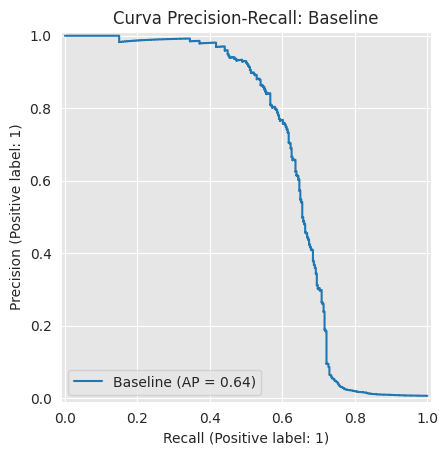

In [55]:
results = []
results.append(evaluate_model(base_model, test_set, strategy_name="Baseline"))

### 5.2. Undersampling (RandomUnderSampler)

Reduz o número de amostras da classe majoritária para balancear o dataset.

É necessário subamostrar sequências, pois caso seja subamostrado o set de transações, se perde boa parte das sequências, e portanto o treinamento se torna extremamente ruim para utilização posterior.

In [56]:
undersampled_model = create_model()

def apply_undersampling(dataset, y_seq):
    # for undersampling
    undersampler = RandomUnderSampler(random_state=42)

    # Criando index para relacionar com as sequências
    idx_X = np.arange(len(y_seq)).reshape(-1, 1)  # shape: (N, 1)

    rus = RandomUnderSampler(random_state=42)
    # selecionando índices aleatórios
    selected_idx, y_balanced = rus.fit_resample(idx_X, y_seq)
    selected_idx = selected_idx.ravel()

    dataset.y = dataset.y[selected_idx]
    dataset.sequences_ids = dataset.sequences_ids[selected_idx]

from copy import deepcopy

undersampled_train_set = deepcopy(training_set)
apply_undersampling(undersampled_train_set, training_set.y)

print("Sequências originais:", training_set.sequences_ids.shape)
print("Sequências após subamostragem:", undersampled_train_set.sequences_ids.shape)
print("Número de transações fraudulentas", np.sum(undersampled_train_set.y == 1))

train_model(undersampled_model, undersampled_train_set)

Sequências originais: (66928, 5)
Sequências após subamostragem: (1266, 5)
Número de transações fraudulentas 633
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6876       0.5000        0.6834  0.1165
      2        0.6775       0.5000        0.6743  0.1257
      3        0.6671       0.5157        0.6648  0.1287
      4        0.6561       0.5669        0.6541  0.1258
      5        0.6435       0.6339        0.6423  0.1264
      6        0.6295       0.6457        0.6294  0.1235
      7        0.6141       0.6929        0.6152  0.1385
      8        0.5973       0.7244        0.5996  0.1191
      9        0.5788       0.7362        0.5828  0.1237
     10        0.5588       0.7677        0.5653  0.1199
     11        0.5377       0.7835        0.5463  0.1166
     12        0.5155       0.7835        0.5270  0.1177
     13        0.4931       0.7835        0.5078  0.1181
     14        0.4698       0.791


--- Avaliando: Undersampling ---
F1-score: 0.1649
Precisão Média (Average Precision): 0.3441


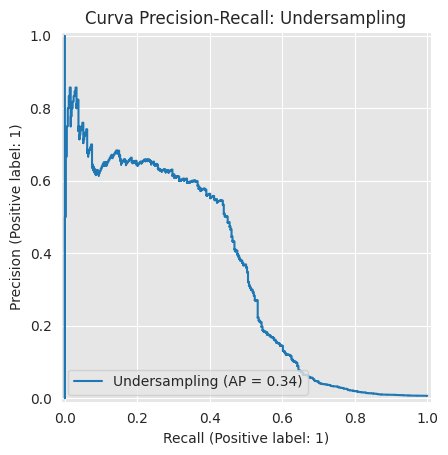

In [57]:
results.append(evaluate_model(undersampled_model, test_set, strategy_name="Undersampling"))

### 5.3. Oversampling

Enquanto foi utilizado SMOTE para os outros modelos, com LSTM queremos analisar dependências temporais e de sequência. Interpolação de amostras para criação de novas não funciona bem para esse caso.

Por esse motivo, será utilizado random oversampling no lugar de SMOTE.

In [58]:
oversampled_model = create_model()

def apply_oversampling(dataset, y_seq):
    # for oversampling
    oversampler = RandomOverSampler(random_state=42)

    # Criando index para relacionar com as sequências
    idx_X = np.arange(len(y_seq)).reshape(-1, 1)  # shape: (N, 1)

    rus = RandomOverSampler(random_state=42)
    # selecionando índices aleatórios
    selected_idx, y_balanced = rus.fit_resample(idx_X, y_seq)
    selected_idx = selected_idx.ravel()

    dataset.y = dataset.y[selected_idx]
    dataset.sequences_ids = dataset.sequences_ids[selected_idx]

from copy import deepcopy

oversampled_train_set = deepcopy(training_set)
apply_oversampling(oversampled_train_set, training_set.y)

print("Sequências originais:", training_set.sequences_ids.shape)
print("Sequências após subamostragem:", oversampled_train_set.sequences_ids.shape)
print("Número de transações fraudulentas", np.sum(oversampled_train_set.y == 1))

train_model(oversampled_model, oversampled_train_set)

Sequências originais: (66928, 5)
Sequências após subamostragem: (132590, 5)
Número de transações fraudulentas 66295
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.3750       0.8722        0.3275  13.0632
      2        0.2926       0.8921        0.3089  12.9874
      3        0.2642       0.9002        0.2957  12.8876
      4        0.2370       0.9052        0.2915  14.0380
      5        0.2096       0.8818        0.3061  13.2066
      6        0.1817       0.8567        0.3081  13.1429
      7        0.1532       0.8388        0.3178  12.8988
      8        0.1246       0.8357        0.3312  12.8931
      9        0.0996       0.8279        0.3648  12.9161
     10        0.0788       0.8531        0.3363  13.5505
     11        0.0639       0.8597        0.3411  12.8841
     12        0.0520       0.8964        0.2567  12.9092
     13        0.0432       0.8749        0.3343  12.9139
     14       


--- Avaliando: Random Oversampling ---
F1-score: 0.1510
Precisão Média (Average Precision): 0.5104


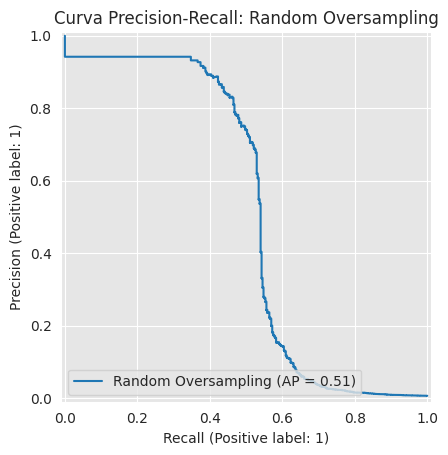

In [59]:
results.append(evaluate_model(oversampled_model, test_set, strategy_name="Random Oversampling"))

### 5.4. Cost-Sensitive Learning (Ajuste de `class_weight`)

Em vez de reamostrar os dados, esta abordagem atribui pesos diferentes às classes durante o treinamento, penalizando mais os erros na classe minoritária. Muitos modelos do scikit-learn (como `LogisticRegression`, `SVC`, `RandomForestClassifier`) possuem o parâmetro `class_weight`.

In [65]:
weight = np.sum(training_set.y == 0) / np.sum(training_set.y == 1)
print("weight", weight)

cost_sensitive_model = create_model(
  torch.tensor([weight])
)

train_model(cost_sensitive_model, training_set)

weight 104.73143759873618
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0942       0.9673        0.8381  9.1482
      2        0.7788       0.9629        0.7539  6.2297
      3        0.7296       0.9549        0.7294  6.9843
      4        0.6988       0.9307        0.7198  6.6645
      5        0.6852       0.9674        0.7087  6.6170
      6        0.6657       0.9583        0.6929  7.2489
      7        0.6508       0.9621        0.6899  6.5622
      8        0.6371       0.9744        0.6985  7.4093
      9        0.6247       0.9639        0.6720  6.5496
     10        0.6131       0.9604        0.6761  7.1314
     11        0.6026       0.9662        0.6664  6.7150
     12        0.5947       0.9812        0.7545  7.7940
     13        0.5896       0.9670        0.6659  8.6694
     14        0.5794       0.9777        0.6906  6.7704
     15        0.5711       0.9693        0.6909  8.8787
     


--- Avaliando: Cost-Sensitive ---
F1-score: 0.3005
Precisão Média (Average Precision): 0.6139


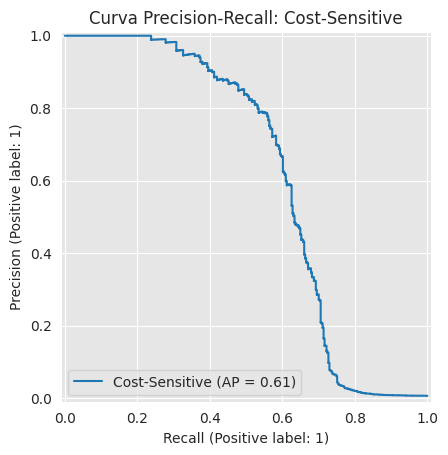

In [66]:
results.append(evaluate_model(cost_sensitive_model, test_set, strategy_name="Cost-Sensitive"))

## 6. Comparação dos Resultados

Vamos consolidar e exibir os resultados de todas as estratégias para uma comparação fácil.


--- Comparação de Resultados ---
                     f1_score  average_precision
strategy                                        
Baseline             0.670886           0.643453
Undersampling        0.164948           0.344051
Random Oversampling  0.150955           0.510368
Cost-Sensitive       0.300506           0.613852


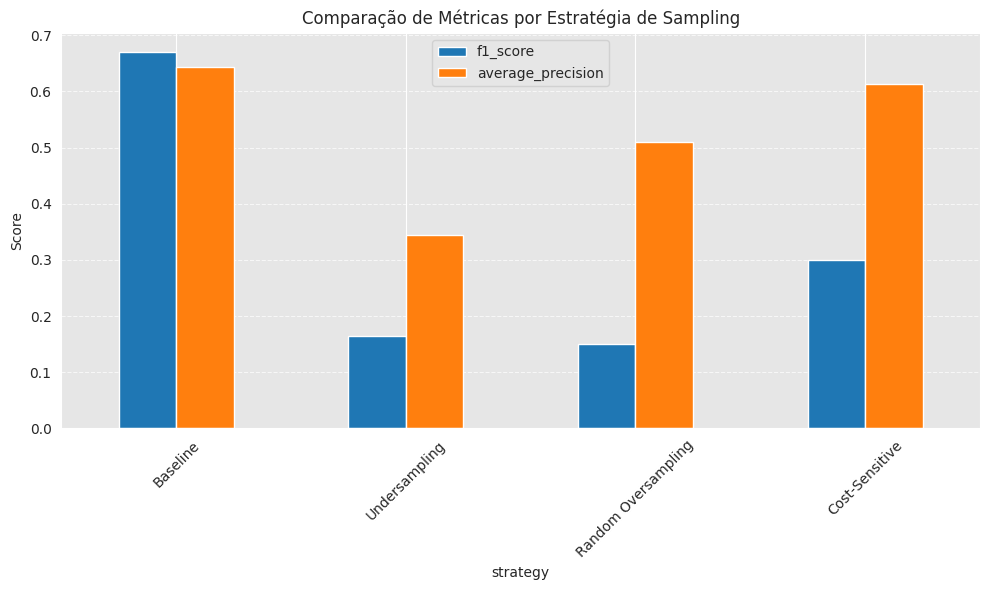

In [67]:
results_df = pd.DataFrame(results)
print("\n--- Comparação de Resultados ---")
print(results_df.set_index('strategy'))

results_df.set_index('strategy').plot(kind='bar', figsize=(10, 6))
plt.title('Comparação de Métricas por Estratégia de Sampling')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

O oversampling